# ROI Interaction

In [41]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

from keras.models import model_from_json
from keras.optimizers import SGD

import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
## Read in facebook rollup data and cluster data
fb = pd.concat([pd.read_csv('data/view_brand_rollup_facebook_1k-10k.tsv', delimiter='\t'),
                pd.read_csv('data/view_brand_rollup_facebook_10kplus.tsv', delimiter='\t')])

In [43]:
clusters = pd.read_csv('utils/clusters.csv')
clusters['flop'] = np.where(clusters['DomesticGross']<clusters['budget'], 1, 0)

In [44]:
len(fb['movie_id'].unique())

610

In [45]:
len(clusters['brand_ods_id'].unique())

526

In [46]:
min(pd.to_datetime(fb['data_for']).dt.year)

2010

In [47]:
data = pd.merge(fb, clusters, left_on = 'movie_id', right_on = 'brand_ods_id' , how = 'left')

data['data_for']= pd.to_datetime(data['data_for']) 
data['released_on'] = pd.to_datetime(data['released_on'])
data['days_after_release'] = data['data_for'] - data['released_on']

In [48]:
## drop flop == NaN for now
data = data[data['flop'].notna()]

In [49]:
## choose -90 to 0 days before release
data = data[(data['days_after_release'] <= '0 days') & (data['days_after_release'] >= '-90 days')]

In [50]:
data.head()

,movie_id,data_for,likes_c,likes,talking_about_c,talking_about,engagement_rate_c,engagement_rate,total_post_c,total_post,...,genre_grouped,inflated_budget,budget_cat,inflated_boxoffice,year_q_bin,rank,production_company_bin,cluster_id,flop,days_after_release
1450,5871,2013-12-21,11427.0,544879.0,6532.0,100263.0,57.16,18.40,1,120,...,Fantasy,0.353173,HighBudget,0.119744,1.0,19.0,Top100,7.0,0.0,-90 days
1451,5871,2013-12-22,5716.0,550595.0,52766.0,153029.0,923.13,27.79,1,121,...,Fantasy,0.353173,HighBudget,0.119744,1.0,19.0,Top100,7.0,0.0,-89 days
1452,5871,2013-12-23,4881.0,555476.0,26397.0,179426.0,540.81,32.30,1,122,...,Fantasy,0.353173,HighBudget,0.119744,1.0,19.0,Top100,7.0,0.0,-88 days
1453,5871,2013-12-24,5977.0,561453.0,7735.0,187161.0,129.41,33.34,0,122,...,Fantasy,0.353173,HighBudget,0.119744,1.0,19.0,Top100,7.0,0.0,-87 days
1454,5871,2013-12-25,4772.0,566225.0,12587.0,199748.0,263.77,35.28,1,123,...,Fantasy,0.353173,HighBudget,0.119744,1.0,19.0,Top100,7.0,0.0,-86 days


In [51]:
data.columns

Index(['movie_id', 'data_for', 'likes_c', 'likes', 'talking_about_c',
       'talking_about', 'engagement_rate_c', 'engagement_rate', 'total_post_c',
       'total_post', 'total_post_likes_c', 'total_post_likes',
       'total_post_shares_c', 'total_post_shares', 'total_post_comments_c',
       'total_post_comments', 'total_post_love_count_c',
       'total_post_love_count', 'total_post_wow_count_c',
       'total_post_wow_count', 'total_post_haha_count_c',
       'total_post_haha_count', 'total_post_sad_count_c',
       'total_post_sad_count', 'total_post_angry_count_c',
       'total_post_angry_count', 'total_post_thankful_count_c',
       'total_post_thankful_count', 'total_post_tracked_reactions_c',
       'total_post_tracked_reactions', 'total_post_reactions_count_c',
       'total_post_reactions_count', 'total_post_interactions_c',
       'total_post_interactions', 'total_post_video_c', 'total_post_video',
       'total_post_video_interactions_c', 'total_post_video_interactions',

In [52]:
data = data[['movie_id', 'total_post_interactions', 'total_post_interactions_c', 'days_after_release', 'flop']]

## 30 days before movie release

In [53]:
data_30 = data[data['days_after_release'] == '-30 days']

In [54]:
data_30_success = data_30[data_30['flop'] == 0]
data_30_flop = data_30[data_30['flop'] == 1]

(array([294.,  28.,  13.,   6.,   9.,   1.,   3.,   2.,   3.,   2.,   3.,
          1.,   1.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([3.32000000e+02, 3.12278370e+06, 6.24523540e+06, 9.36768710e+06,
        1.24901388e+07, 1.56125905e+07, 1.87350422e+07, 2.18574939e+07,
        2.49799456e+07, 2.81023973e+07, 3.12248490e+07, 3.43473007e+07,
        3.74697524e+07, 4.05922041e+07, 4.37146558e+07, 4.68371075e+07,
        4.99595592e+07, 5.30820109e+07, 5.62044626e+07, 5.93269143e+07,
        6.24493660e+07, 6.55718177e+07, 6.86942694e+07, 7.18167211e+07,
        7.49391728e+07, 7.80616245e+07, 8.11840762e+07, 8.43065279e+07,
        8.74289796e+07, 9.05514313e+07, 9.36738830e+07]),
 <a list of 30 Patch objects>)

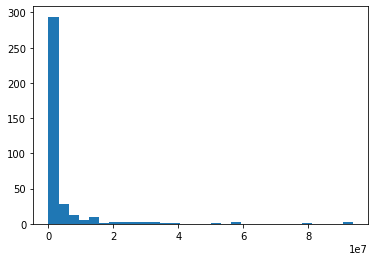

In [55]:
plt.hist(data_30_success['total_post_interactions'], bins = 30)

In [59]:
trial_movie = data[data['movie_id'] == 5871]

In [61]:
trial_movie.head()

,movie_id,total_post_interactions,total_post_interactions_c,days_after_release,flop
1450,5871,948661,32515,-90 days,0.0
1451,5871,982852,34191,-89 days,0.0
1452,5871,1014374,31522,-88 days,0.0
1453,5871,1028739,14365,-87 days,0.0
1454,5871,1052281,23542,-86 days,0.0


(array([29.,  6.,  9.,  4.,  7., 14.,  5.,  1.,  3.,  2.,  1.,  2.,  1.,
         1.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([   445. ,   6068.3,  11691.6,  17314.9,  22938.2,  28561.5,
         34184.8,  39808.1,  45431.4,  51054.7,  56678. ,  62301.3,
         67924.6,  73547.9,  79171.2,  84794.5,  90417.8,  96041.1,
        101664.4, 107287.7, 112911. , 118534.3, 124157.6, 129780.9,
        135404.2, 141027.5, 146650.8, 152274.1, 157897.4, 163520.7,
        169144. ]),
 <a list of 30 Patch objects>)

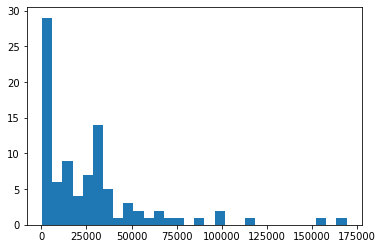

In [62]:
plt.hist(trial_movie['total_post_interactions_c'], bins = 30)

In [16]:
data_30_flop.head()

,movie_id,total_post_interactions,days_after_release,flop
35443,10692,85126,-30 days,1.0
64292,10669,1421255,-30 days,1.0
65315,10623,108608,-30 days,1.0
86155,13370,228336,-30 days,1.0
86744,10643,272014,-30 days,1.0


(array([127.,   8.,   8.,   3.,   1.,   3.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00000000e+00, 3.87525250e+06, 7.75050500e+06, 1.16257575e+07,
        1.55010100e+07, 1.93762625e+07, 2.32515150e+07, 2.71267675e+07,
        3.10020200e+07, 3.48772725e+07, 3.87525250e+07, 4.26277775e+07,
        4.65030300e+07, 5.03782825e+07, 5.42535350e+07, 5.81287875e+07,
        6.20040400e+07, 6.58792925e+07, 6.97545450e+07, 7.36297975e+07,
        7.75050500e+07, 8.13803025e+07, 8.52555550e+07, 8.91308075e+07,
        9.30060600e+07, 9.68813125e+07, 1.00756565e+08, 1.04631818e+08,
        1.08507070e+08, 1.12382322e+08, 1.16257575e+08]),
 <a list of 30 Patch objects>)

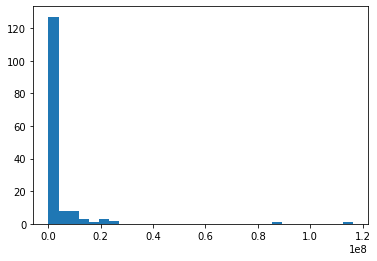

In [17]:
plt.hist( data_30_flop['total_post_interactions'], bins = 30)

### non-parametric statistical tests.

In [18]:
################################################################################################################

## Non-parametric statistical tests

In [19]:
import scipy.stats as sps
from scipy import stats
import statistics

### Two sample ks test to compare distributions
#### Null hypothesis (H0): both samples come from the same distribution

In [20]:
KS_30 = sps.ks_2samp(data_30_success['total_post_interactions'], data_30_flop['total_post_interactions'])

In [21]:
KS_30

Ks_2sampResult(statistic=0.1429618768328446, pvalue=0.02058760294381301)

#### p-value = 0.021 < alpha = 0.05. Reject the null hypothesis and conclude that the two distributions are different.

In [22]:
#############################################################################################################

### Kruskal Wallis Test to compare medians in two distributions
#### Null hypothesis (H0): population medians are equal.

In [23]:
## Calculate medians
Median_success_30 = statistics.median(data_30_success['total_post_interactions'])
Median_success_30

372811.5

In [24]:
Median_flop_30 = statistics.median(data_30_flop['total_post_interactions'])
Median_flop_30

230431.5

In [25]:
KW_30 = stats.kruskal(data_30_success['total_post_interactions'], data_30_flop['total_post_interactions'])
KW_30

KruskalResult(statistic=5.4208274739278295, pvalue=0.01989792758755015)

#### p-value = 0.020 < alpha = 0.05. Reject the null hypothesis and conclude that population medians are different.

In [26]:
#################################################################################################################

### Mann Whitney U test to compare means in two distributions

In [27]:
MWU_30 = stats.mannwhitneyu(data_30_success['total_post_interactions'], data_30_flop['total_post_interactions'])
MWU_30

MannwhitneyuResult(statistic=24951.0, pvalue=0.009957330898400776)

#### p-value = 0.010 < alpha = 0.05. Reject the null hypothesis and conclude that population means are different.

In [28]:
################################################################################################################

## 60 days before movie release

In [29]:
data_60 = data[data['days_after_release'] == '-60 days']

In [30]:
data_60_success = data_60[data_60['flop'] == 0]
data_60_flop = data_60[data_60['flop'] == 1]

(array([300.,  22.,  13.,   8.,   6.,   1.,   3.,   2.,   6.,   0.,   2.,
          2.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([       0.        ,  3097291.53333333,  6194583.06666667,
         9291874.6       , 12389166.13333333, 15486457.66666667,
        18583749.2       , 21681040.73333333, 24778332.26666667,
        27875623.8       , 30972915.33333333, 34070206.86666667,
        37167498.4       , 40264789.93333333, 43362081.46666667,
        46459373.        , 49556664.53333333, 52653956.06666666,
        55751247.59999999, 58848539.13333333, 61945830.66666666,
        65043122.2       , 68140413.73333333, 71237705.26666667,
        74334996.8       , 77432288.33333333, 80529579.86666666,
        83626871.39999999, 86724162.93333334, 89821454.46666667,
        92918746.        ]),
 <a list of 30 Patch objects>)

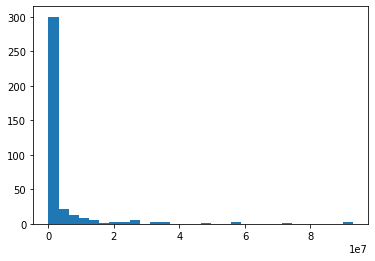

In [31]:
plt.hist( data_60_success['total_post_interactions'], bins = 30)

### Two sample ks test to compare distributions
#### Null hypothesis (H0): both samples come from the same distribution

In [32]:
KS_60 = sps.ks_2samp(data_60_success['total_post_interactions'], data_60_flop['total_post_interactions'])
KS_60

Ks_2sampResult(statistic=0.1497182063219799, pvalue=0.013373693781115192)

#### p-value = 0.013 < alpha = 0.05. Reject the null hypothesis and conclude that the two distributions are different.

In [33]:
#################################################################################################################

### Kruskal Wallis Test to compare medians in two distributions
#### Null hypothesis (H0): population medians are equal.

In [34]:
## Calculate medians
Median_success_60 = statistics.median(data_60_success['total_post_interactions'])
Median_success_60

255251

In [35]:
Median_flop_60 = statistics.median(data_60_flop['total_post_interactions'])
Median_flop_60

129277.0

In [36]:
KW_60 = stats.kruskal(data_60_success['total_post_interactions'], data_60_flop['total_post_interactions'])
KW_60

KruskalResult(statistic=4.805189258346484, pvalue=0.02837414999426217)

#### p-value = 0.028 < alpha = 0.05. Reject the null hypothesis and conclude that population medians are different.

In [37]:
################################################################################################################

### Mann Whitney U test to compare means in two distributions

In [38]:
MWU_60 = stats.mannwhitneyu(data_60_success['total_post_interactions'], data_60_flop['total_post_interactions'])
MWU_60

MannwhitneyuResult(statistic=25098.0, pvalue=0.014198484003561869)

#### p-value = 0.010 < alpha = 0.05. Reject the null hypothesis and conclude that population means are different.

In [44]:
################################################################################################################